Python-AWIPS Tutorial Notebook

---


# Objectives

* Use python-awips to connect to an edex server
* Define and filter data request for model sounding data
* Create vertical profiles from GFS BUFR products
* Use MetPy to create [SkewT](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.SkewT.html) and [Hodograph](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.Hodograph.html) plots

---

## Table of Contents

[1 Imports](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#imports)<br>  
[2 EDEX Connection](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#edex-connection)<br>  
[3 Setting Location](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#setting-location)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Available Location Names](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#available-location-names)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Setting the Location Name](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#setting-the-location-name)<br>  
[4 Filtering by Time](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#filtering-by-time)<br>  
[5 Get the Data!](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#get-the-data)<br>  
[6 Use the Data!](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#use-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.1 Prepare the Data!](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#prepare-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.2 Calculate Dewpoint from Specific Humidity](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#calculate-dewpoint-from-specific-humidity)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.2.1 Method 1](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#method-1)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.2.2 Method 2](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#method-2)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.2.3 Method 3](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#method-3)<br>  
[7 Plot the Data!](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#plot-the-data)<br>  
[8 See Also](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#see-also)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.1 Related Notebooks](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#related-notebooks)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.2 Additional Documentation](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html#additional-documentation)<br>  

## 1 Imports

The imports below are used throughout the notebook.  Note the first import is coming directly from python-awips and allows us to connect to an EDEX server.  The subsequent imports are for data manipulation and visualization. 

In [1]:
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import exp, log
import numpy as np
from metpy.calc import dewpoint, vapor_pressure, wind_speed, wind_direction
from metpy.plots import SkewT, Hodograph
from metpy.units import units

[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---

## 2 EDEX Connection

First we establish a connection to Unidata's public EDEX server.  With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to ***modelsounding***, and define additional parameters and an identifier on the request.

In [2]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest("modelsounding")
forecastModel = "GFS"
request.addIdentifier("reportType", forecastModel)
request.setParameters("pressure","temperature","specHum","uComp","vComp")

[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---

## 3 Setting Location

### 3.1 Available Location Names
When working with a new data type, it is often useful to investigate all available options for a particular setting.  Shown below is how to see all available location names for a data request with type `modelsounding` and `reportType` identifier of `GFS`.  This step is not necessary if you already know exactly what the location name(s) you're interested in is.

In [3]:
locations = DataAccessLayer.getAvailableLocationNames(request)
locations.sort()
list(locations)

['',
 '1V4',
 '3J2',
 '4BL',
 '4BQ',
 '4HV',
 '4OM',
 '5AF',
 '5AG',
 '5SZ',
 '6RO',
 '8V7',
 '9B6',
 'A#2',
 'A#3',
 'A#4',
 'A#5',
 'A#6',
 'A#7',
 'A#8',
 'A#9',
 'A#A',
 'A#B',
 'ABL',
 'ADM',
 'AFA',
 'AGR',
 'AHN',
 'AIA',
 'AIH',
 'AJO',
 'ANJ',
 'APX',
 'AQQ',
 'ATH',
 'ATL1',
 'ATL2',
 'ATL3',
 'ATL4',
 'ATLH',
 'AWH',
 'AWR',
 'B#1',
 'B#2',
 'B#3',
 'B#4',
 'B#5',
 'B#6',
 'B#7',
 'B#8',
 'B#9',
 'B#A',
 'B#B',
 'B#C',
 'B#D',
 'B#E',
 'B#F',
 'B#G',
 'B#H',
 'B#J',
 'B#K',
 'B#L',
 'B#M',
 'B#N',
 'B#O',
 'B#P',
 'B#Q',
 'B#S',
 'BAB',
 'BDG',
 'BDP',
 'BFL',
 'BGTL',
 'BH1',
 'BH2',
 'BH3',
 'BH4',
 'BH5',
 'BHK',
 'BID',
 'BIR',
 'BLS',
 'BLU',
 'BMX',
 'BNA',
 'BOD',
 'BRA',
 'BTL',
 'BVR',
 'C01',
 'C02',
 'C03',
 'C04',
 'C06',
 'C07',
 'C08',
 'C09',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22',
 'C23',
 'C24',
 'C25',
 'C27',
 'C28',
 'C30',
 'C31',
 'C32',
 'C33',
 'C34',
 'C35',
 'C36',
 'C7H',
 'CAI',
 'CAN',
 'CBE',
 'CBN

### 3.2 Setting the Location Name

In this case we're setting the location name to `KFRM` which is the Municipal Airport in Fairmont, Minnesota.

In [4]:
request.setLocationNames("KFRM")

[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---

## 4 Filtering by Time

Models produce many different time variants during their runs, so let's limit the data to the most recent time and forecast run.

In [5]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)

try:
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)
    list(fcstRun)
    response = DataAccessLayer.getGeometryData(request,[fcstRun[0]])
except:
    print('No times available')
    exit

[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---

## 5 Get the Data!

Here we can now request our data response from the EDEX server with our defined time filter.
Printing out some data about the response verifies we received the data we were interested in.

In [6]:
obj = response[0]

print("parms    = " + str(obj.getParameters()))
print("site     = " + str(obj.getLocationName()))
print("geom     = " + str(obj.getGeometry()))
print("datetime = " + str(obj.getDataTime()))
print("reftime  = " + str(obj.getDataTime().getRefTime()))
print("fcstHour = " + str(obj.getDataTime().getFcstTime()))
print("period   = " + str(obj.getDataTime().getValidPeriod()))

parms    = ['temperature', 'pressure', 'vComp', 'uComp', 'specHum']
site     = KFRM
geom     = POINT (-94.41999816894531 43.65000152587891)
datetime = 2022-08-19 12:00:00
reftime  = Aug 19 22 12:00:00 GMT
fcstHour = 0
period   = (Aug 19 22 12:00:00 , Aug 19 22 12:00:00 )


[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---

## 6 Use the Data!

Since we filtered on time, and requested the data in the previous cell, we now have a `response` object we can work with.

### 6.2 Prepare data objects

Here we construct arrays for each parameter to plot (temperature, pressure, moisture (spec. humidity), wind components, and cloud cover).  We have two sets of arrays for temperature and pressure, where the second set only has values as long as the specific humidity is not zero.  That is because we are going to do some calculations with specific humidity, temperature, and pressure and we need all those arrays to be the same length, and for the specific humidty to not equal zero.

In [7]:
# Create new arrays to populate from our response objects
tmp,prs,sh,prs2,tmp2 = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
uc,vc = np.array([]),np.array([])

# Cycle through all response objects to populate new arrays
for ob in response:
    tmp = np.append(tmp,ob.getNumber("temperature"))
    prs = np.append(prs,ob.getNumber("pressure"))
    uc = np.append(uc,ob.getNumber("uComp"))
    vc = np.append(vc,ob.getNumber("vComp"))
    # don't include data with 0 specific humidity
    if(ob.getNumber("specHum")==0):
        continue
    sh = np.append(sh,ob.getNumber("specHum"))
    prs2 = np.append(prs2,ob.getNumber("pressure"))
    tmp2 = np.append(tmp2,ob.getNumber("temperature"))

### 6.2 Calculate Dewpoint from Specific Humidity

Because the modelsounding plugin does not return dewpoint values, we must calculate the profile ourselves.  Here are three examples of dewpoint calculated from specific humidity, including a manual calculation following NCEP AWIPS/NSHARP. 

First, we'll set up variables that are used in all three methods (and later in the notebook).

In [8]:
tfull = (tmp-273.15) * units.degC
t = (tmp2-273.15) * units.degC

pfull = prs/100 * units.mbar
p = prs2/100 * units.mbar

u,v = uc*1.94384,vc*1.94384 # m/s to knots
spd = wind_speed(u*units.knots, v*units.knots)
dir = wind_direction(u*units.knots, v*units.knots) * units.deg

#### 6.2.1 Method 1

Here we'll calculate the dewpoint using MetPy calculated mixing ratio and the vapor pressure.

In [9]:
rmix = (sh/(1-sh)) *1000 * units('g/kg')
e = vapor_pressure(p, rmix)
td = dewpoint(e)

#### 6.2.2 Method 2

Here we'll calculate dewpoint using MetPy while assuming the mixing ratio is equal to the specific humidity.

In [10]:
td2 = dewpoint(vapor_pressure(p, sh))

#### 6.2.3 Method 3

Here we use logic from the NCEP AWIPS soundingrequest plugin.  This logic was based on [GEMPAK and NSHARP calculations](https://github.com/Unidata/awips2-ncep/blob/unidata_16.2.2/edex/gov.noaa.nws.ncep.edex.plugin.soundingrequest/src/gov/noaa/nws/ncep/edex/plugin/soundingrequest/handler/MergeSounding.java#L1783).

In [11]:
# new arrays
ntmp = tmp2

# where p=pressure(pa), T=temp(C), T0=reference temp(273.16)
rh = 0.263*prs2*sh / (np.exp(17.67*ntmp/(ntmp+273.15-29.65)))
vaps =  6.112 * np.exp((17.67 * ntmp) / (ntmp + 243.5))
vapr = rh * vaps / 100
dwpc = np.array(243.5 * (np.log(6.112) - np.log(vapr)) / (np.log(vapr) - np.log(6.112) - 17.67)) * units.degC

[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---

## 7 Plot the Data!

Create and display SkewT and Hodograph plots using MetPy.

Since we're displaying all three dewpoint plots, we also create a "zoomed in" view to highlight the slight differences between the three calculations.

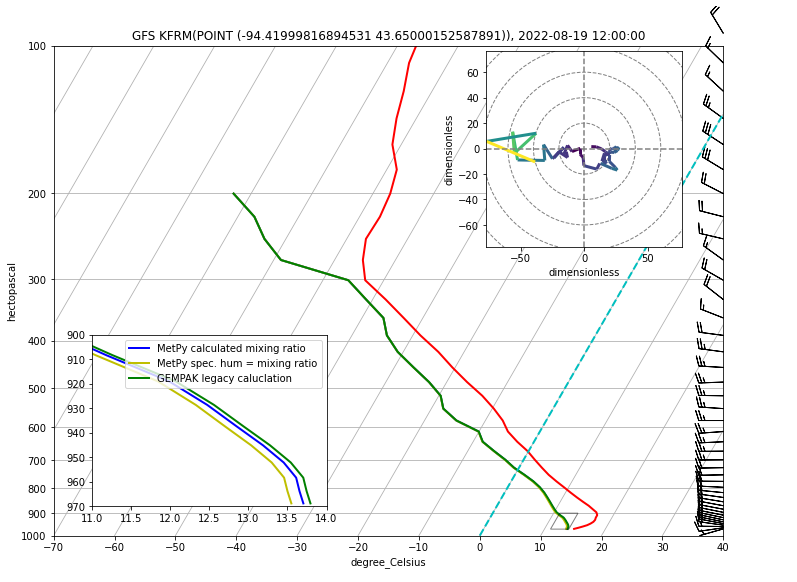

In [12]:
# Create a new figure and define the size
fig = plt.figure(figsize=(12, 14))

# Create a skewT plot
skew = SkewT(fig)

# Plot the data
skew.plot(pfull, tfull, 'r', linewidth=2)
skew.plot(p, td, 'b', linewidth=2)
skew.plot(p, td2, 'y', linewidth=2)
skew.plot(p, dwpc, 'g', linewidth=2)
skew.plot_barbs(pfull, u, v)
# set the domain and range (these may need to be adjusted
# depending on the exact data for best viewing purposes)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-70, 40)

# Add a title to the plot
plt.title( forecastModel + " " \
          + ob.getLocationName() \
          + "("+ str(ob.getGeometry()) + ")" \
          + ", " + str(ob.getDataTime()))

# Create a secondary axes for the "zoomed in" view
zoom_ax = inset_axes(skew.ax, '35%', '35%', loc=3,
                     bbox_to_anchor=(.05, .05, 1, 1),
                     bbox_transform=skew.ax.transAxes)
# create a secondary plot for zoomed in section
fig2 = plt.figure()
skew2 = SkewT(fig2)
skew2.ax = zoom_ax
skew2.plot(p, td, 'b', linewidth=2, label='MetPy calculated mixing ratio')
skew2.plot(p, td2, 'y', linewidth=2, label='MetPy spec. hum = mixing ratio')
skew2.plot(p, dwpc, 'g', linewidth=2, label='GEMPAK legacy caluclation')
# create a legend to explain the three lines
skew2.ax.legend(loc=1)
# remove the axis title on the zoomed plot since they
# are redundant and just clutter the plot
skew2.ax.set_xlabel("")
skew2.ax.set_ylabel("")
# these exact bounds may need to change depending on
# the most recent data
skew2.ax.set_ylim(970, 900)
skew2.ax.set_xlim(11, 14)

# draw an indicator in the main plot of the "zoomed in" region
skew.ax.indicate_inset_zoom(zoom_ax, edgecolor="black")

# dispose of the second figure, since creating a new
# skewt in metpy automatically creates a new figure
# which is unnecessary in this case
plt.close(fig2)

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=spd.max()/units.knots)
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()

[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---

## See Also

### Related Notebooks

* [Grid Levels and Parameters](https://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)
* [Upper Air BUFR Soundings](http://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)
* [Forecast Model Vertical Sounding](http://unidata.github.io/python-awips/examples/generated/Forecast_Model_Vertical_Sounding.html)

### Additional Documentation

**python-awips:**
* [awips.DataAccessLayer](http://unidata.github.io/python-awips/api/DataAccessLayer.html)
* [awips.PyGeometryData](http://unidata.github.io/python-awips/api/PyGeometryData.html)

**matplotlib:**
* [matplotlib.pyplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html)
* [metpy.skewt](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.SkewT.html)

[Top](https://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

---